In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path

import pandas as pd
import numpy as np
import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.mixed_effects_human import MixedEffectsHuman
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
data = DataClass(config)

DATASET_REAL = 'real_data/dnc_info_2022-05-26.parquet'
DATASET_REAL_METADATA = 'dnc_info_2022-05-26_settings.json'

df = pd.read_parquet(os.path.join(data.data_path, DATASET_REAL))
df = data.clean_human_data(df, muscle="EDB")

# participants = ["cornptio012", "cornptio013", "cornptio015", "scapptio001"]
# idx = df.participant.isin(participants)
# df = df[idx].reset_index(drop=True).copy()

df, encoder_dict = data.build(df)

2023-05-15 20:28:46,962 - hb_mep.utils.utils - INFO - func:clean_human_data took: 0.12 sec
2023-05-15 20:28:46,964 - hb_mep.data_access.core - INFO - Processing data ...
2023-05-15 20:28:46,979 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-05-15 20:28:46,979 - hb_mep.utils.utils - INFO - func:build took: 0.02 sec


#### Plot

In [5]:
# plot(df=df, encoder_dict=encoder_dict);

#### Initialize model

In [6]:
model = MixedEffectsHuman(config)

#### Run MCMC inference

In [7]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-05-15 20:28:47,451 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-15 20:28:47,452 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-15 20:28:47,452 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-15 20:28:47,454 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-15 20:28:47,454 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-05-15 20:28:47,503 - hb_mep.models.mixed_effects_human - INFO - Running inference with Mixed_E

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

2023-05-15 20:37:41,015 - hb_mep.utils.utils - INFO - func:run_inference took: 8 min and 53.57 sec


#### Diagnostics

In [8]:
mcmc.print_summary(prob=.95)


                                   mean       std    median      2.5%     97.5%     n_eff     r_hat
                       b[0,0]      0.21      0.12      0.20      0.00      0.42    971.82      1.01
                       b[0,1]      0.95      0.17      0.93      0.65      1.29    848.29      1.00
                       b[0,2]      0.55      0.10      0.54      0.36      0.76    472.73      1.01
                       b[0,3]      0.52      0.41      0.43      0.00      1.30   1209.15      1.01
                       b[0,4]      0.03      0.01      0.02      0.01      0.04    866.78      1.01
                       b[0,5]      0.51      0.42      0.41      0.00      1.31   1587.62      1.00
                       b[0,6]      0.52      0.41      0.44      0.00      1.31   1308.49      1.00
                       b[0,7]      1.10      0.09      1.10      0.92      1.26    697.77      1.00
                       b[0,8]      0.52      0.42      0.42      0.00      1.33   1324.02      1.00

#### Plot fitted curves

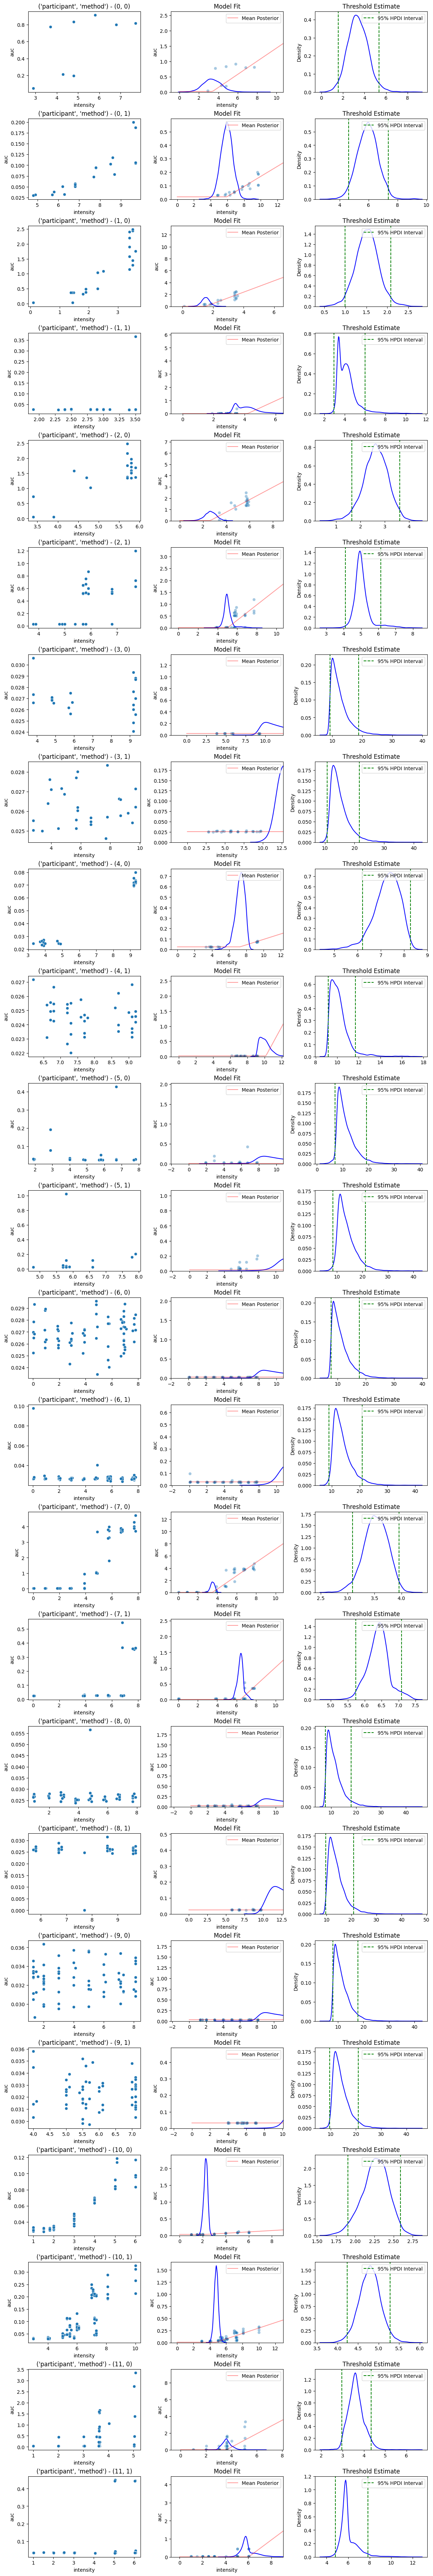

In [9]:
model.plot(df=df, posterior_samples=posterior_samples);

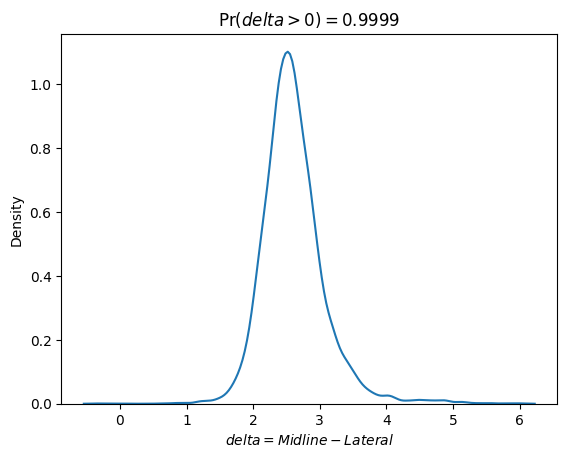

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

samples = posterior_samples["delta_mean"]
pr = (samples > 0).mean()

sns.kdeplot(samples)
plt.title(f"$\Pr (delta > 0) = {pr : .04}$")
plt.xlabel(f"$delta = Midline - Lateral$");